## 2 Nearest Neighbor Classification on Real Data

### 2.1 Exploring the Data

In [1]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt

digits = load_digits ()
print(digits.keys())
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [2]:
print(data.dtype)
print(data.shape)

float64
(1797, 64)


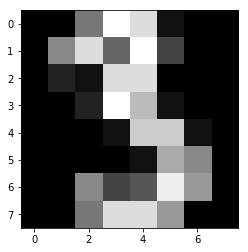

In [3]:
img = images[3]
plt.figure()
plt.gray()
plt.imshow(img, interpolation="nearest")
plt.show()

In [4]:
from sklearn import model_selection

X_all = data
y_all = target

X_train, X_test, y_train, y_test = model_selection.train_test_split(digits.data, digits.target, test_size=0.4, random_state=0)

### 2.2 Distance function computation using loops

In [5]:
def dist_loop(training, test):
    N = training.shape[0]
    M = test.shape[0]
    dists = np.empty((N,M), dtype=np.float32)
    
    for i in range(N):
        for j in range(M):
            dists[i,j] = np.linalg.norm(training[i] - test[j])
            
    return dists

In [6]:
%timeit dist_loop(X_train, X_test)

3.01 s ± 91.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 2.3 Distance function computation using vectorization

In [7]:
def dist_vec(training, test):
    return np.linalg.norm(training[:,np.newaxis,:] - test[np.newaxis,:,:], axis=2)

In [8]:
%timeit dist_vec(X_train, X_test)

350 ms ± 7.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 2.4 Implement the nearest neighbor classifier

In [9]:
from scipy import stats

def rule_k_nearest_neighbors(k, training, train_labels, test):
    M = test.shape[0]
    dists = dist_vec(training, test) #N*M
    k_smallest = np.argpartition(dists, k, axis=0)[:k,:] #k*M
    labels = train_labels[k_smallest.flatten()].reshape(k,M)
    return stats.mode(labels, axis=0)[0]

In [10]:
def two_digit_error(i, j, k=1):
    pos_train = (y_train == i) | (y_train == j)
    X_train_ij = X_train[pos_train]
    y_train_ij = y_train[pos_train]
    pos_test = (y_test == i) | (y_test == j)
    X_test_ij = X_test[pos_test]
    y_test_ij = y_test[pos_test]

    return np.count_nonzero(rule_k_nearest_neighbors(k, X_train_ij, y_train_ij, X_test_ij) - y_test_ij) / y_test_ij.size

print("error for distinguishing 1s and 3s: {:5.4f}".format(two_digit_error(1,3)))
print("error for distinguishing 1s and 7s: {:5.4f}".format(two_digit_error(1,7)))
print("error for distinguishing 3s and 9s: {:5.4f}".format(two_digit_error(3,9)))

error for distinguishing 1s and 3s: 0.0000
error for distinguishing 1s and 7s: 0.0000
error for distinguishing 3s and 9s: 0.0139


### 2.5 Generalize to k-nearest neighbors 

In [11]:
ks = [1,3,5,9,17,33]
print("distinguishing 3s and 9s:")
for k in ks:
    print("k = {:2d}, error = {:5.4f}".format(k, two_digit_error(3, 9, k)))

distinguishing 3s and 9s:
k =  1, error = 0.0139
k =  3, error = 0.0069
k =  5, error = 0.0069
k =  9, error = 0.0069
k = 17, error = 0.0069
k = 33, error = 0.0208


The classification performance is best for intermediate values of k. Between k=3 and k=17 the minimal error rate of 0.7% is achieved, the extreme values of k=1 and k=33 yield significantly worse results.

## 3 Cross-validation

In [12]:
def generate_folds(X, y, n):
    return np.array_split(X, n), np.array_split(y, n)


def generate_CV_sets(X, y, n):
    X_folds, y_folds = generate_folds(X, y, n)
    splits = np.array_split(np.arange(len(X)), n)
    dsets = []
    for i in range(n):
        X_train = np.delete(X, splits[i], axis=0)
        y_train = np.delete(y, splits[i], axis=0)
        X_test = X_folds[i]
        y_test = y_folds[i]
        dsets.append([X_train, y_train, X_test, y_test])
    return dsets

# rule is a function of the form (X_train, y_train, X_test) -> y_test
def cross_validation_error(rule, X, y, n):
    dsets = generate_CV_sets(X, y, n)
    errors = np.empty(n, dtype=np.float32)
    for i, dset in enumerate(dsets):
        X_train, y_train, X_test, y_test = dset
        y_test_predicted = rule(X_train, y_train, X_test)
        errors[i] = np.average(y_test_predicted != y_test)
    return np.average(errors), np.std(errors)


In [16]:
from sklearn import neighbors

X, y = data, target
ns = [2,5,10]

own_rule = lambda X_train, y_train, X_test: rule_k_nearest_neighbors(1, X_train, y_train, X_test)

def sklearn_rule(X_train, y_train, X_test):
    sklearn_NN = neighbors.KNeighborsClassifier(n_neighbors=1)
    sklearn_NN.fit(X_train, y_train)
    return sklearn_NN.predict(X_test)
    
print("-"*14+"own implementation"+"-"*15)
for n in ns:
    error, error_std = cross_validation_error(own_rule, X, y, n)
    print("n = {:2d}, mean error = {:5.4f}, error std = {:5.4f}".format(n, error, error_std))


print("-"*9+"sklearn KNeighborsClassifier"+"-"*10)
for n in ns:
    error, error_std = cross_validation_error(sklearn_rule, X, y, n)
    print("n = {:2d}, mean error = {:5.4f}, error std = {:5.4f}".format(n, error, error_std))

--------------own implementation---------------
n =  2, mean error = 0.0406, error std = 0.0016
n =  5, mean error = 0.0350, error std = 0.0129
n = 10, mean error = 0.0239, error std = 0.0176
---------sklearn KNeighborsClassifier----------
n =  2, mean error = 0.0401, error std = 0.0011
n =  5, mean error = 0.0350, error std = 0.0129
n = 10, mean error = 0.0239, error std = 0.0176
